<a href="https://colab.research.google.com/github/eubielaraujo/Confusion_Matrix/blob/main/Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x=train_images,
          y=train_labels,
          epochs=10,
          validation_data=(test_images, test_labels))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 43ms/step - accuracy: 0.3376 - loss: 1.7897 - val_accuracy: 0.5401 - val_loss: 1.2712
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 42ms/step - accuracy: 0.5669 - loss: 1.2201 - val_accuracy: 0.5748 - val_loss: 1.1898
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 41ms/step - accuracy: 0.6283 - loss: 1.0483 - val_accuracy: 0.6456 - val_loss: 0.9977
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.6667 - loss: 0.9421 - val_accuracy: 0.6584 - val_loss: 0.9614
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 43ms/step - accuracy: 0.6939 - loss: 0.8613 - val_accuracy: 0.6742 - val_loss: 0.9266
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.7192 - loss: 0.8009 - val_accuracy: 0.6782 - val_loss: 0.9157
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.7372 - loss: 0.7435 - val_accuracy: 0.6854 - val_loss: 0.9250
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.7543 - loss: 0.70

In [9]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [11]:
cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

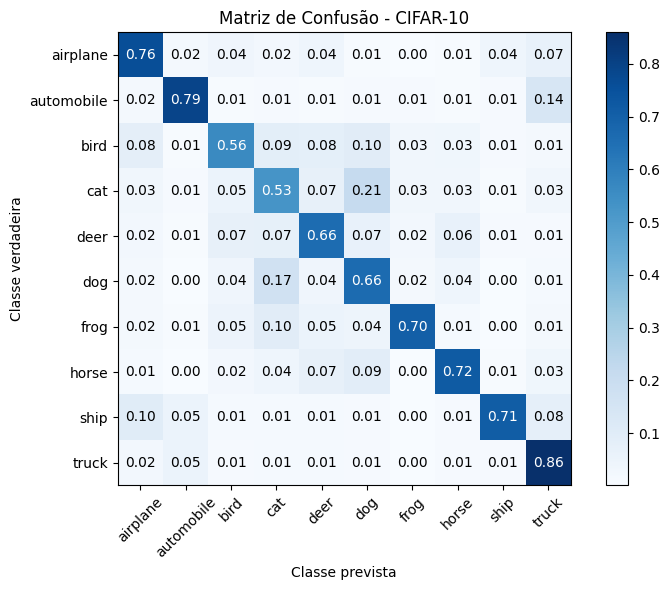

In [16]:
plt.figure(figsize=(8,6))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - CIFAR-10")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

plt.ylabel("Classe verdadeira")
plt.xlabel("Classe prevista")
plt.tight_layout()
plt.show()